# Prediction in an Era of Unpredictability

In [25]:
import codecs
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import string

from pprint import pprint
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Research questions

To better dissect the data and extract insights, we will explore the following questions:

1. Which socio-economic factors have the biggest impact, if any, in building or altering popular opinion?
    * Standard and Quality of Education (Wikidata, Educational databases)
    * Income and Inequality Levels (Wikidata)
</br>

2. How does media through newspapers and social networks influence these events through information or misinformation?
    * Newspaper (Corpus Data)
    * Social Media (Twitter)
</br>

3. What is the influence of the political system in place?
    * Political System
    * Rate of Abstention (Wikidata)
    * Demonstrations Covered in Media (Corpus Data)
</br>

4. How far in time could we have traced the roots of such events? (Wikidata, Newspapers)

### 1. Which socio-economic factors have the biggest impact, if any, in building or altering popular opinion?

#### Standard and Quality of Education (Wikidata)

In [26]:
edu_df = pd.DataFrame(columns=['Country',
                               'Total Literacy',
                               'Secondary Diploma',
                               'Post-Secondary Diploma',
                               'Total Enrolled',
                               'National Education Budget'])

In [27]:
edu_df.loc[len(edu_df)] = ['United States',
                           '100%',
                           '81%',
                           '30%',
                           '81.5 million',
                           '1 trillion']

edu_df.loc[len(edu_df)] = ['United Kingdom',
                           '99%',
                           '87%',
                           '41%',
                           '11.7 million',
                           '62.2 billion']

edu_df.loc[len(edu_df)] = ['Spain',
                           '98.1%',
                           '45.4%',
                           '38.1%',
                           '5.9 million',
                           '4.04 billion']

In [28]:
edu_df.head()

,Country,Total Literacy,Secondary Diploma,Post-Secondary Diploma,Total Enrolled,National Education Budget
0,United States,100%,81%,30%,81.5 million,1 trillion
1,United Kingdom,99%,87%,41%,11.7 million,62.2 billion
2,Spain,98.1%,45.4%,38.1%,5.9 million,4.04 billion


Sources: 
- https://en.wikipedia.org/wiki/Education_in_the_United_States
- https://en.wikipedia.org/wiki/Education_in_England
- https://en.wikipedia.org/wiki/List_of_Ministers_of_Education_of_Spain

#### Income and Inequality Levels (Wikidata)

### 2. How does media through newspapers and social networks influence these events through information or misinformation?

For this question, we will focus on newspaper articles from the United States, United Kingdom, and Spain from the News On The Web Corpus Dataset. In terms of data collection, we will rely on articles regarding the U.S 2016 Presidential Election.

To select the appropriate articles, we iterate through all of the articles from 2016 within the corpus and only select those with key terms relevant to this topic (i.e. 'election', 'Trump', etc). Once we have these relevant articles, we convert the text to lowercase, remove the punctuation so words are not tokenized with the punctuation marks, remove common stopwords from the text, and then find the most important or trending words using the method described below.
 

We use the Term Frequency (TF) and Inverse Document Frequency (IDF) methods as discussed in class and the previous homework.
- TF for a term “t” is defined as the count of a term “t” in a document “D”
- IDF for a term is defined as logarithm of ratio of total documents available in the corpus and number of documents containing the term "T"

After extracting the appropriate articles about the election, we will compute the TF - IDF features to find words that score the highest in this set of articles.

Later, when scaling to the full dataset on the cluster, we will select the top 20 words for each article and then use clustering techniques to find articles with close word associations.

In [29]:
SOURCE_1_PATH = "./Data/now_sources_pt1.txt"
SOURCE_2_PATH = "./Data/now_sources_pt2.txt"
DATA_PATH = "./Data/16-10-us.txt"
ENCODING = "latin1"

COLUMN_NAMES = ['TextID',
                'Number of Words',
                'Date',
                'Country',
                'Source',
                'Link',
                'Headline']

In [30]:
with codecs.open(SOURCE_1_PATH, "r", encoding=ENCODING) as f:
    pt1 = pd.read_csv(f, sep="\t", names = COLUMN_NAMES)
    
pt1.head()

,TextID,Number of Words,Date,Country,Source,Link,Headline
0,1334669,334,10-01-01,US,The Next Web,http://thenextweb.com/2010/01/01/avatar-takes-...,Believe it or not: Avatar takes 1 petabyte of ...
1,1334671,493,10-01-01,US,People Magazine,"http://www.people.com/people/article/0,,203339...",INSIDE STORY: The Making of Beyonc's 'Single ...
2,1334672,1255,10-01-01,US,San Francisco Chronicle,http://www.sfgate.com/bayarea/article/Biblical...,"Biblical scholar's date for rapture: May 21, 2011"
3,1334673,695,10-01-01,US,CNN,http://www.cnn.com/2010/HEALTH/01/01/multi.vit...,What you need to know about multivitamins
4,1334674,724,10-01-01,US,MedPage Today,http://www.medpagetoday.com/Psychiatry/sleepdi...,Lack of Sleep Linked to Depression in Adolescents


In [31]:
with codecs.open(SOURCE_2_PATH, "r", encoding="latin1") as f:
    pt2 = pd.read_csv(f, sep="\t", names = COLUMN_NAMES)
    
pt2.head()

,TextID,Number of Words,Date,Country,Source,Link,Headline
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ..."


### Newspaper Contents

In [32]:
# read all the lines in the file
with codecs.open(DATA_PATH, "r", encoding=ENCODING) as f:
    lines = f.readlines()

# list to store all the lines read from the data file
data = []

# append all the lines to the list called data
for line in lines:
    data.append(line)

# create DataFrame using the list of lines
df = pd.DataFrame(data, columns=["Content"])
df.head(10)

,Content
0,@@14637197 <p> NEW YORK ( AP ) -- Donald Trump...
1,@@14637200 <h> Here 's all the crazy stuff tha...
2,@@14637201 <h> Another hotel wants to build in...
3,"@@14637202 <p> In this Sept. 23 , 2016 photo ,..."
4,@@14637203 <h> Court erases jury award of puni...
5,@@14637204 <p> A flurry of small earthquakes n...
6,@@14637207 <h> After a dominant win over Stanf...
7,@@14637209 <h> Story Highlights <p> A dramatic...
8,@@14637213 <h> Hueneme suffers first loss of s...
9,@@14637215 <p> CLOVERDALE -- A Napoleon woman ...


We replace all the punctuations in the text with a space. We first tried to replace it with an empty sequence but that replaces words such as "Trump's" with "Trumps". More importantly, finding all the relevant keywords using a regex also selects articles with words "trumpets", "selection", etc. which have the words "trump", "election" as substrings. So, we try to find the words "trump ", "election ", both ending with a space. So we need to replace punctuations with a space to find those words.

In [33]:
# function to replace all the punctuations with a space
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, " ")
    return text

# convert all text to lowercase
df["Content"] = df["Content"].str.lower()

# apply function to the given column
df["Content"] = df["Content"].apply(remove_punctuations)

print(df.head(10))
print("\nNumber of articles = {}".format(df.shape[0]))

                                             Content
0    14637197  p  new york   ap      donald trump...
1    14637200  h  here  s all the crazy stuff tha...
2    14637201  h  another hotel wants to build in...
3    14637202  p  in this sept  23   2016 photo  ...
4    14637203  h  court erases jury award of puni...
5    14637204  p  a flurry of small earthquakes n...
6    14637207  h  after a dominant win over stanf...
7    14637209  h  story highlights  p  a dramatic...
8    14637213  h  hueneme suffers first loss of s...
9    14637215  p  cloverdale    a napoleon woman ...

Number of articles = 1000


In [34]:
# to store all the articles relevant to our project from the file
relevant_keywords = ["election",
                     "trump",
                     "donald"
                     "clinton",
                     "hillary"]

# NOTE: add a space between the OR | symbol between the words so
# we do not choose words which have relevant words as substrings
relevant_regex = " |".join(relevant_keywords)

# find all articles which contain any of the relevant keywords
df = df[df["Content"].str.contains(relevant_regex)]

print(df.head(10))
print("\nNumber of articles = {}".format(df.shape[0]))

                                              Content
0     14637197  p  new york   ap      donald trump...
10    14637217  h  utility  s rates   old market f...
44    14638417  p  file   in this june 5   2015   ...
45    14638418  p  iowa city    a powerful univers...
54    14638430  h  tired of the rancor of presiden...
77    14639013  h  start listening to audiobooks w...
81    14639017  h  with the death of shimon peres ...
87    14639582  p  wbns tv  s on line public inspe...
92    14639591  h  multiple fresh signs of economi...
95    14639594  p  a new president will take the o...

Number of articles = 116


#### Find most important and trending words using TF-IDF

In [35]:
print("Finding trending words in {} articles\n".format(df.shape[0]))

vectorizer = TfidfVectorizer(stop_words="english")

vectors = vectorizer.fit_transform(df.Content)
print("Converted text into vectors of shape {}".format(vectors.shape))

weights = np.asarray(vectors.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({
                "feature": vectorizer.get_feature_names(),
                "tfidf": weights
            })

sorted_df = weights_df.sort_values(by="tfidf", ascending=False)
sorted_df.head(25)

Finding trending words in 116 articles

Converted text into vectors of shape (116, 10161)


,feature,tfidf
9447,trump,0.071417
8013,said,0.041611
1938,clinton,0.035538
9073,tax,0.031292
3203,election,0.024458
3004,donald,0.021548
6190,new,0.020607
1598,campaign,0.020297
9076,taxes,0.020268
9252,times,0.020098


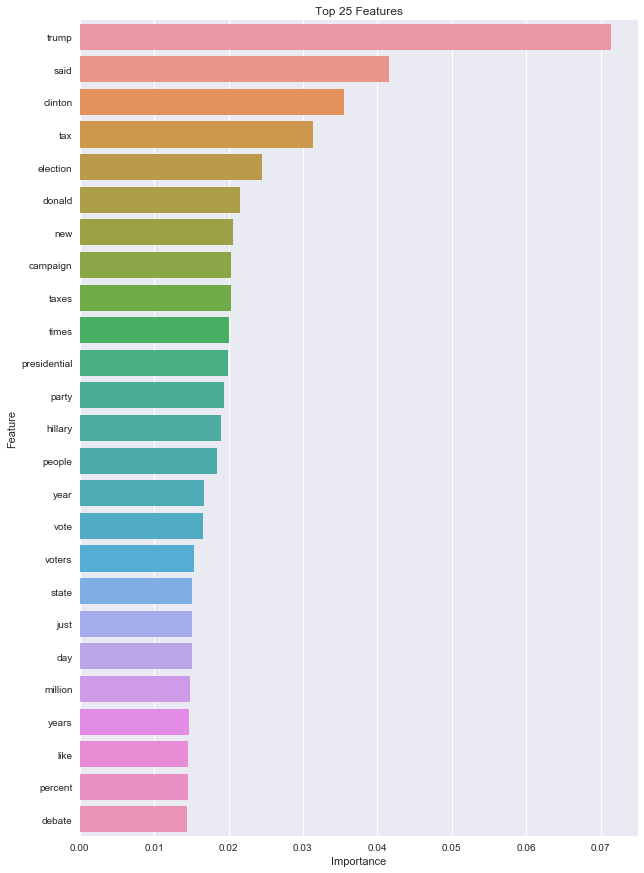

In [40]:
plt.figure(figsize=(10, 15))

ax = sns.barplot(
        x="tfidf",
        y="feature",
        data=sorted_df[0:25])

ax.set_title("Top 25 Features")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")

plt.show()